# Комплексная оценка системы Journey Agent

Этот ноутбук:
1. Генерирует 20 тестовых запросов через OpenAI LLM
2. Сохраняет запросы в CSV файл
3. Вызывает систему Journey Agent с этими запросами
4. Сохраняет ответы системы в CSV
5. Оценивает качество ответов через 3 агентов-оценщиков
6. Агрегирует и выводит финальные результаты

## Инструкции по запуску

```bash
# Запустите Docker с Weaviate
docker-compose up -d weaviate contextionary
```


## 1. Настройка и импорты


In [1]:
import sys
import os
from pathlib import Path

# Добавляем корневую директорию проекта в путь
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"Project root: {project_root}")


Project root: /Users/andreisuhov/Desktop/llm/Journey_agent


In [2]:
import json
import pandas as pd
import numpy as np
from typing import List, Dict, Any, Optional
from dataclasses import dataclass, field
from tqdm import tqdm
from datetime import datetime
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=ResourceWarning)

# Загружаем переменные окружения из .env
from dotenv import load_dotenv
load_dotenv(project_root / ".env")

# OpenAI
from openai import OpenAI

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
print(f"OpenAI API Key: {'✓ загружен' if OPENAI_API_KEY else '✗ НЕ НАЙДЕН'}")

# Инициализация OpenAI клиента
client = OpenAI(api_key=OPENAI_API_KEY)


OpenAI API Key: ✓ загружен


In [3]:
# Импорт функции вызова системы
from src.main_pipeline import main_pipeline
from src.tgbot.agent_stub import process_route_request

print("✓ Функции системы импортированы")


/Users/andreisuhov/miniconda3/envs/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Функции системы импортированы


## 2. Генерация тестовых запросов через OpenAI


In [4]:
def generate_test_queries(num_queries: int = 20) -> List[str]:
    """
    Генерирует тестовые запросы для системы Journey Agent через OpenAI.
    
    Запросы должны быть разнообразными и охватывать различные сценарии:
    - Разные города (Москва, Санкт-Петербург)
    - Разные типы мероприятий (концерты, выставки, театр, спорт)
    - Разные временные рамки (выходные, вечер, целый день)
    - Разные интересы и бюджеты
    """
    
    prompt = f"""
Ты генератор тестовых запросов для системы планирования маршрутов выходного дня.
Система помогает пользователям находить мероприятия и составлять маршруты.

Сгенерируй ровно {num_queries} различных запросов от пользователей. Запросы должны быть:

1. **Разнообразными по городам**: Москва и Санкт-Петербург (примерно поровну)
2. **Разнообразными по типам мероприятий**:
   - Концерты (классика, рок, джаз)
   - Выставки и музеи
   - Театры и спектакли
   - Мастер-классы (кулинария, творчество)
   - Детские мероприятия
   - Экскурсии
3. **Разнообразными по формату**:
   - Краткие запросы: "Хочу на выставку в Москве"
   - Детальные запросы с ограничениями: "Планирую выходные в Питере, бюджет 5000 рублей, интересует искусство"
   - Запросы с временными рамками: "Что посетить вечером в субботу?"
4. **Реалистичными** - такие, какие мог бы написать реальный пользователь

Верни JSON массив строк с запросами. Только JSON, без объяснений:
["запрос1", "запрос2", ...]
"""
    
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "Ты помощник для генерации тестовых данных. Отвечай только JSON."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.9,
        max_tokens=2000
    )
    
    # Парсим JSON ответ
    content = response.choices[0].message.content.strip()
    # Убираем markdown если есть
    if content.startswith("```"):
        content = content.split("```")[1]
        if content.startswith("json"):
            content = content[4:]
    
    queries = json.loads(content)
    return queries[:num_queries]

print("Функция генерации запросов готова")


Функция генерации запросов готова


In [ ]:
# Генерируем 20 тестовых запросов
print("🔄 Генерация 20 тестовых запросов...")
test_queries = generate_test_queries(20)

print(f"\n✓ Сгенерировано {len(test_queries)} запросов:\n")
for i, q in enumerate(test_queries, 1):
    print(f"{i:2d}. {q}")


In [5]:
# Сохраняем запросы в CSV

test_queries = [
  "Хочется в Москве сначала сходить на выставку современного искусства, а потом где-нибудь вкусно поужинать рядом",
  "В Питере хочу спланировать субботу: днём музей, вечером концерт чего-нибудь спокойного",
  "Хочется необычного спорта в Москве в субботу, чтобы не просто фитнес",
  "В Санкт-Петербурге хочется поделать что-нибудь руками, типа мастер-класса, а потом прогуляться",
  "Ищу в Москве идею для воскресенья: сначала экскурсия, потом кафе",
  "Хочу в Питере сходить с ребёнком на что-нибудь интересное, а после — перекусить",
  "В Москве хочется культурный маршрут: выставка, потом театр в один вечер",
  "Планирую выходной в Петербурге, бюджет около 5000, хочется искусства и уюта",
  "Хочется в Москве джазовый концерт вечером в субботу и место поесть рядом",
  "В Питере хочу что-нибудь необычное: может интерактивный музей и мастер-класс",
  "В Москве хочется активного отдыха днём и спокойного вечера с едой",
  "Ищу в Санкт-Петербурге маршрут на воскресенье: музей + прогулка + кафе",
  "Хочется сходить в Москве на кулинарный мастер-класс и потом поесть то, что приготовили",
  "В Питере думаю начать день с экскурсии, а закончить концертом",
  "В Москве хочется чего-нибудь творческого, не просто музей",
  "Планирую субботу в Санкт-Петербурге: детское мероприятие, потом семейный ресторан",
  "Хочу в Москве сначала посмотреть выставку, а потом сходить на рок-концерт",
  "В Питере хочется спокойный маршрут: театр вечером и ужин после",
  "Ищу в Москве идеи, куда сходить вдвоём в выходной, чтобы и интересно, и поесть",
  "В Санкт-Петербурге хочется попробовать что-нибудь новое: мастер-класс или необычную экскурсию"
]

testing_data_path = project_root / "data" / "testing_data"
testing_data_path.mkdir(parents=True, exist_ok=True)

queries_df = pd.DataFrame({
    "query_id": range(1, len(test_queries) + 1),
    "query": test_queries,
    "generated_at": datetime.now().isoformat()
})

queries_file = testing_data_path / "system_eval_queries.csv"
queries_df.to_csv(queries_file, index=False, encoding="utf-8")

print(f"✓ Запросы сохранены в: {queries_file}")
queries_df.head()


✓ Запросы сохранены в: /Users/andreisuhov/Desktop/llm/Journey_agent/data/testing_data/system_eval_queries.csv


,query_id,query,generated_at
0,1,Хочется в Москве сначала сходить на выставку с...,2025-12-27T00:14:28.177455
1,2,В Питере хочу спланировать субботу: днём музей...,2025-12-27T00:14:28.177455
2,3,"Хочется необычного спорта в Москве в субботу, ...",2025-12-27T00:14:28.177455
3,4,В Санкт-Петербурге хочется поделать что-нибудь...,2025-12-27T00:14:28.177455
4,5,Ищу в Москве идею для воскресенья: сначала экс...,2025-12-27T00:14:28.177455


## 3. Вызов системы с тестовыми запросами


In [6]:
def call_system(query: str) -> Dict[str, Any]:
    """
    Вызывает систему Journey Agent с запросом.
    Возвращает результат и метаданные.
    """
    start_time = datetime.now()
    
    try:
        # Используем main_pipeline напрямую для получения ответа
        response = main_pipeline(query)
        status = "success"
        error = None
    except Exception as e:
        response = f"Error: {str(e)}"
        status = "error"
        error = str(e)
    
    end_time = datetime.now()
    duration = (end_time - start_time).total_seconds()
    
    return {
        "response": response,
        "status": status,
        "error": error,
        "duration_seconds": duration
    }

print("Функция вызова системы готова")


Функция вызова системы готова


In [7]:
# Вызываем систему для каждого запроса
print("🔄 Вызов системы с тестовыми запросами...\n")

results = []

for i, query in enumerate(tqdm(test_queries, desc="Обработка запросов")):
    print(f"\n[{i+1}/{len(test_queries)}] Запрос: {query[:60]}...")
    
    result = call_system(query)
    
    results.append({
        "query_id": i + 1,
        "query": query,
        "response": result["response"],
        "status": result["status"],
        "error": result["error"],
        "duration_seconds": result["duration_seconds"]
    })
    
    print(f"   Статус: {result['status']}, Время: {result['duration_seconds']:.2f}с")

print(f"\n✓ Обработано {len(results)} запросов")


🔄 Вызов системы с тестовыми запросами...



Обработка запросов:   0%|          | 0/20 [00:00<?, ?it/s]


[1/20] Запрос: Хочется в Москве сначала сходить на выставку современного ис...

🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
НАЧАЛО РАБОТЫ ГРАФА ПЛАНИРОВАНИЯ
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
Событий для планирования: 15
Максимальное количество итераций: 1

▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
УЗЕЛ: planner_reasoning
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶

🤔 ПЛАНИРОВЩИК: Начинаю анализ и рассуждения...
Анализирую 15 событий
Отправляю запрос к LLM для анализа...
💡 LLM может использовать инструменты для получения дополнительной информации
✅ Рассуждения получены:
   - Соображений: 3
   - Проблем выявлено: 2
   - Стратегия: Сначала я выберу выставку современного искусства, которая будет посещена первой. Затем я найду ближа...

▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
УЗЕЛ: planner_create
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶

📋 ПЛАНИРОВЩИК: Создаю план похода...
Использую предыдущие рассуждения
Отправляю запрос к LLM для создания плана...
💡 LLM может использовать инструменты для получения информации о маршрутах и погоде
✅ План создан:


Обработка запросов:   5%|▌         | 1/20 [01:03<19:57, 63.05s/it]

   Статус: success, Время: 63.05с

[2/20] Запрос: В Питере хочу спланировать субботу: днём музей, вечером конц...

🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
НАЧАЛО РАБОТЫ ГРАФА ПЛАНИРОВАНИЯ
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
Событий для планирования: 15
Максимальное количество итераций: 1

▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
УЗЕЛ: planner_reasoning
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶

🤔 ПЛАНИРОВЩИК: Начинаю анализ и рассуждения...
Анализирую 15 событий
Отправляю запрос к LLM для анализа...
💡 LLM может использовать инструменты для получения дополнительной информации
✅ Рассуждения получены:
   - Соображений: 3
   - Проблем выявлено: 3
   - Стратегия: Сначала выбрать музей, который открыт днём, а затем найти подходящий концерт спокойной музыки, котор...

▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
УЗЕЛ: planner_create
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶

📋 ПЛАНИРОВЩИК: Создаю план похода...
Использую предыдущие рассуждения
Отправляю запрос к LLM для создания плана...
💡 LLM может использовать инструменты для получения информации о 

Обработка запросов:  10%|█         | 2/20 [01:34<13:18, 44.36s/it]

   Статус: success, Время: 31.27с

[3/20] Запрос: Хочется необычного спорта в Москве в субботу, чтобы не прост...

🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
НАЧАЛО РАБОТЫ ГРАФА ПЛАНИРОВАНИЯ
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
Событий для планирования: 15
Максимальное количество итераций: 1

▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
УЗЕЛ: planner_reasoning
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶

🤔 ПЛАНИРОВЩИК: Начинаю анализ и рассуждения...
Анализирую 15 событий
Отправляю запрос к LLM для анализа...
💡 LLM может использовать инструменты для получения дополнительной информации
✅ Рассуждения получены:
   - Соображений: 3
   - Проблем выявлено: 2
   - Стратегия: Сначала уточнить, какие именно субботы интересуют пользователя, затем проверить доступность мероприя...

▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
УЗЕЛ: planner_create
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶

📋 ПЛАНИРОВЩИК: Создаю план похода...
Использую предыдущие рассуждения
Отправляю запрос к LLM для создания плана...
💡 LLM может использовать инструменты для получения информации о 

Обработка запросов:  15%|█▌        | 3/20 [02:06<11:02, 38.94s/it]

   Статус: success, Время: 32.50с

[4/20] Запрос: В Санкт-Петербурге хочется поделать что-нибудь руками, типа ...

🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
НАЧАЛО РАБОТЫ ГРАФА ПЛАНИРОВАНИЯ
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
Событий для планирования: 15
Максимальное количество итераций: 1

▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
УЗЕЛ: planner_reasoning
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶

🤔 ПЛАНИРОВЩИК: Начинаю анализ и рассуждения...
Анализирую 15 событий
Отправляю запрос к LLM для анализа...
💡 LLM может использовать инструменты для получения дополнительной информации
✅ Рассуждения получены:
   - Соображений: 3
   - Проблем выявлено: 3
   - Стратегия: Сначала определить доступные мастер-классы и экскурсии, затем проверить их время и адреса. После это...

▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
УЗЕЛ: planner_create
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶

📋 ПЛАНИРОВЩИК: Создаю план похода...
Использую предыдущие рассуждения
Отправляю запрос к LLM для создания плана...
💡 LLM может использовать инструменты для получения информации о 

Обработка запросов:  20%|██        | 4/20 [02:35<09:18, 34.92s/it]

   Статус: success, Время: 28.75с

[5/20] Запрос: Ищу в Москве идею для воскресенья: сначала экскурсия, потом ...

🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
НАЧАЛО РАБОТЫ ГРАФА ПЛАНИРОВАНИЯ
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
Событий для планирования: 15
Максимальное количество итераций: 1

▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
УЗЕЛ: planner_reasoning
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶

🤔 ПЛАНИРОВЩИК: Начинаю анализ и рассуждения...
Анализирую 15 событий
Отправляю запрос к LLM для анализа...
💡 LLM может использовать инструменты для получения дополнительной информации
✅ Рассуждения получены:
   - Соображений: 3
   - Проблем выявлено: 3
   - Стратегия: Планирование маршрута должно начинаться с выбора экскурсии на смотровой площадке PANORAMA360, после ...

▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
УЗЕЛ: planner_create
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶

📋 ПЛАНИРОВЩИК: Создаю план похода...
Использую предыдущие рассуждения
Отправляю запрос к LLM для создания плана...
💡 LLM может использовать инструменты для получения информации о 

Обработка запросов:  25%|██▌       | 5/20 [03:11<08:50, 35.38s/it]

   Статус: success, Время: 36.19с

[6/20] Запрос: Хочу в Питере сходить с ребёнком на что-нибудь интересное, а...

🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
НАЧАЛО РАБОТЫ ГРАФА ПЛАНИРОВАНИЯ
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
Событий для планирования: 15
Максимальное количество итераций: 1

▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
УЗЕЛ: planner_reasoning
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶

🤔 ПЛАНИРОВЩИК: Начинаю анализ и рассуждения...
Анализирую 15 событий
Отправляю запрос к LLM для анализа...
💡 LLM может использовать инструменты для получения дополнительной информации
✅ Рассуждения получены:
   - Соображений: 3
   - Проблем выявлено: 3
   - Стратегия: Сначала уточнить адреса и время мероприятий, которые подходят для посещения с ребенком. Затем выбрат...

▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
УЗЕЛ: planner_create
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶

📋 ПЛАНИРОВЩИК: Создаю план похода...
Использую предыдущие рассуждения
Отправляю запрос к LLM для создания плана...
💡 LLM может использовать инструменты для получения информации о 

Обработка запросов:  30%|███       | 6/20 [03:48<08:21, 35.82s/it]

   Статус: success, Время: 36.67с

[7/20] Запрос: В Москве хочется культурный маршрут: выставка, потом театр в...

🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
НАЧАЛО РАБОТЫ ГРАФА ПЛАНИРОВАНИЯ
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
Событий для планирования: 15
Максимальное количество итераций: 1

▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
УЗЕЛ: planner_reasoning
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶

🤔 ПЛАНИРОВЩИК: Начинаю анализ и рассуждения...
Анализирую 15 событий
Отправляю запрос к LLM для анализа...
💡 LLM может использовать инструменты для получения дополнительной информации
✅ Рассуждения получены:
   - Соображений: 3
   - Проблем выявлено: 3
   - Стратегия: Сначала определить выставку, которая будет проходить в вечернее время, затем найти театральное предс...

▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
УЗЕЛ: planner_create
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶

📋 ПЛАНИРОВЩИК: Создаю план похода...
Использую предыдущие рассуждения
Отправляю запрос к LLM для создания плана...
💡 LLM может использовать инструменты для получения информации о 

Обработка запросов:  35%|███▌      | 7/20 [04:14<07:05, 32.71s/it]

   Статус: success, Время: 26.31с

[8/20] Запрос: Планирую выходной в Петербурге, бюджет около 5000, хочется и...

🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
НАЧАЛО РАБОТЫ ГРАФА ПЛАНИРОВАНИЯ
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
Событий для планирования: 15
Максимальное количество итераций: 1

▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
УЗЕЛ: planner_reasoning
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶

🤔 ПЛАНИРОВЩИК: Начинаю анализ и рассуждения...
Анализирую 15 событий
Отправляю запрос к LLM для анализа...
💡 LLM может использовать инструменты для получения дополнительной информации
✅ Рассуждения получены:
   - Соображений: 3
   - Проблем выявлено: 3
   - Стратегия: Сначала выбрать мероприятия с фиксированным временем, чтобы составить расписание. Затем проверить до...

▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
УЗЕЛ: planner_create
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶

📋 ПЛАНИРОВЩИК: Создаю план похода...
Использую предыдущие рассуждения
Отправляю запрос к LLM для создания плана...
💡 LLM может использовать инструменты для получения информации о 

Обработка запросов:  40%|████      | 8/20 [05:06<07:46, 38.91s/it]

   Статус: success, Время: 52.13с

[9/20] Запрос: Хочется в Москве джазовый концерт вечером в субботу и место ...

🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
НАЧАЛО РАБОТЫ ГРАФА ПЛАНИРОВАНИЯ
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
Событий для планирования: 15
Максимальное количество итераций: 1

▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
УЗЕЛ: planner_reasoning
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶

🤔 ПЛАНИРОВЩИК: Начинаю анализ и рассуждения...
Анализирую 15 событий
Отправляю запрос к LLM для анализа...
💡 LLM может использовать инструменты для получения дополнительной информации
✅ Рассуждения получены:
   - Соображений: 3
   - Проблем выявлено: 2
   - Стратегия: Сначала отфильтровать концерты по дате и времени, затем проверить доступные места для еды рядом с вы...

▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
УЗЕЛ: planner_create
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶

📋 ПЛАНИРОВЩИК: Создаю план похода...
Использую предыдущие рассуждения
Отправляю запрос к LLM для создания плана...
💡 LLM может использовать инструменты для получения информации о 

Обработка запросов:  45%|████▌     | 9/20 [05:49<07:21, 40.09s/it]

   Статус: success, Время: 42.69с

[10/20] Запрос: В Питере хочу что-нибудь необычное: может интерактивный музе...

🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
НАЧАЛО РАБОТЫ ГРАФА ПЛАНИРОВАНИЯ
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
Событий для планирования: 15
Максимальное количество итераций: 1

▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
УЗЕЛ: planner_reasoning
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶

🤔 ПЛАНИРОВЩИК: Начинаю анализ и рассуждения...
Анализирую 15 событий
Отправляю запрос к LLM для анализа...
💡 LLM может использовать инструменты для получения дополнительной информации
✅ Рассуждения получены:
   - Соображений: 3
   - Проблем выявлено: 3
   - Стратегия: Сначала нужно отобрать мероприятия, которые соответствуют критериям пользователя. Затем, используя и...

▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
УЗЕЛ: planner_create
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶

📋 ПЛАНИРОВЩИК: Создаю план похода...
Использую предыдущие рассуждения
Отправляю запрос к LLM для создания плана...
💡 LLM может использовать инструменты для получения информации о

Обработка запросов:  50%|█████     | 10/20 [06:35<06:58, 41.83s/it]

   Статус: success, Время: 45.72с

[11/20] Запрос: В Москве хочется активного отдыха днём и спокойного вечера с...

🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
НАЧАЛО РАБОТЫ ГРАФА ПЛАНИРОВАНИЯ
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
Событий для планирования: 15
Максимальное количество итераций: 1

▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
УЗЕЛ: planner_reasoning
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶

🤔 ПЛАНИРОВЩИК: Начинаю анализ и рассуждения...
Анализирую 15 событий
Отправляю запрос к LLM для анализа...
💡 LLM может использовать инструменты для получения дополнительной информации
✅ Рассуждения получены:
   - Соображений: 3
   - Проблем выявлено: 3
   - Стратегия: Стратегия планирования заключается в том, чтобы сначала выбрать события, подходящие для активного от...

▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
УЗЕЛ: planner_create
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶

📋 ПЛАНИРОВЩИК: Создаю план похода...
Использую предыдущие рассуждения
Отправляю запрос к LLM для создания плана...
💡 LLM может использовать инструменты для получения информации о

Обработка запросов:  55%|█████▌    | 11/20 [07:10<05:57, 39.69s/it]

   Статус: success, Время: 34.82с

[12/20] Запрос: Ищу в Санкт-Петербурге маршрут на воскресенье: музей + прогу...

🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
НАЧАЛО РАБОТЫ ГРАФА ПЛАНИРОВАНИЯ
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
Событий для планирования: 15
Максимальное количество итераций: 1

▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
УЗЕЛ: planner_reasoning
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶

🤔 ПЛАНИРОВЩИК: Начинаю анализ и рассуждения...
Анализирую 15 событий
Отправляю запрос к LLM для анализа...
💡 LLM может использовать инструменты для получения дополнительной информации
✅ Рассуждения получены:
   - Соображений: 3
   - Проблем выявлено: 3
   - Стратегия: Составить маршрут, начиная с посещения Петропавловской крепости, затем перейти к Петербургскому план...

▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
УЗЕЛ: planner_create
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶

📋 ПЛАНИРОВЩИК: Создаю план похода...
Использую предыдущие рассуждения
Отправляю запрос к LLM для создания плана...
💡 LLM может использовать инструменты для получения информации о

Обработка запросов:  60%|██████    | 12/20 [07:56<05:32, 41.57s/it]

   Статус: success, Время: 45.86с

[13/20] Запрос: Хочется сходить в Москве на кулинарный мастер-класс и потом ...

🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
НАЧАЛО РАБОТЫ ГРАФА ПЛАНИРОВАНИЯ
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
Событий для планирования: 15
Максимальное количество итераций: 1

▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
УЗЕЛ: planner_reasoning
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶

🤔 ПЛАНИРОВЩИК: Начинаю анализ и рассуждения...
Анализирую 15 событий
Отправляю запрос к LLM для анализа...
💡 LLM может использовать инструменты для получения дополнительной информации
✅ Рассуждения получены:
   - Соображений: 3
   - Проблем выявлено: 2
   - Стратегия: Провести поиск кулинарных мастер-классов в Москве, которые соответствуют запросу пользователя, и сос...

▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
УЗЕЛ: planner_create
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶

📋 ПЛАНИРОВЩИК: Создаю план похода...
Использую предыдущие рассуждения
Отправляю запрос к LLM для создания плана...
💡 LLM может использовать инструменты для получения информации о

Обработка запросов:  65%|██████▌   | 13/20 [08:36<04:49, 41.38s/it]

   Статус: success, Время: 40.94с

[14/20] Запрос: В Питере думаю начать день с экскурсии, а закончить концерто...

🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
НАЧАЛО РАБОТЫ ГРАФА ПЛАНИРОВАНИЯ
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
Событий для планирования: 15
Максимальное количество итераций: 1

▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
УЗЕЛ: planner_reasoning
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶

🤔 ПЛАНИРОВЩИК: Начинаю анализ и рассуждения...
Анализирую 15 событий
Отправляю запрос к LLM для анализа...
💡 LLM может использовать инструменты для получения дополнительной информации
✅ Рассуждения получены:
   - Соображений: 3
   - Проблем выявлено: 3
   - Стратегия: Создать маршрут, начиная с экскурсии в утреннее или дневное время, затем перемещаться к месту провед...

▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
УЗЕЛ: planner_create
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶

📋 ПЛАНИРОВЩИК: Создаю план похода...
Использую предыдущие рассуждения
Отправляю запрос к LLM для создания плана...
💡 LLM может использовать инструменты для получения информации о

Обработка запросов:  70%|███████   | 14/20 [09:06<03:46, 37.79s/it]

   Статус: success, Время: 29.49с

[15/20] Запрос: В Москве хочется чего-нибудь творческого, не просто музей...

🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
НАЧАЛО РАБОТЫ ГРАФА ПЛАНИРОВАНИЯ
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
Событий для планирования: 15
Максимальное количество итераций: 1

▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
УЗЕЛ: planner_reasoning
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶

🤔 ПЛАНИРОВЩИК: Начинаю анализ и рассуждения...
Анализирую 15 событий
Отправляю запрос к LLM для анализа...
💡 LLM может использовать инструменты для получения дополнительной информации
✅ Рассуждения получены:
   - Соображений: 3
   - Проблем выявлено: 2
   - Стратегия: Сначала отобрать мероприятия, которые соответствуют критериям творческого и интерактивного времяпреп...

▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
УЗЕЛ: planner_create
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶

📋 ПЛАНИРОВЩИК: Создаю план похода...
Использую предыдущие рассуждения
Отправляю запрос к LLM для создания плана...
💡 LLM может использовать инструменты для получения информации о ма

Обработка запросов:  75%|███████▌  | 15/20 [09:46<03:11, 38.40s/it]

   Статус: success, Время: 39.80с

[16/20] Запрос: Планирую субботу в Санкт-Петербурге: детское мероприятие, по...

🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
НАЧАЛО РАБОТЫ ГРАФА ПЛАНИРОВАНИЯ
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
Событий для планирования: 15
Максимальное количество итераций: 1

▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
УЗЕЛ: planner_reasoning
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶

🤔 ПЛАНИРОВЩИК: Начинаю анализ и рассуждения...
Анализирую 15 событий
Отправляю запрос к LLM для анализа...
💡 LLM может использовать инструменты для получения дополнительной информации
✅ Рассуждения получены:
   - Соображений: 3
   - Проблем выявлено: 3
   - Стратегия: Сначала выбрать одно или два мероприятия, которые будут проходить в течение дня, а затем найти ресто...

▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
УЗЕЛ: planner_create
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶

📋 ПЛАНИРОВЩИК: Создаю план похода...
Использую предыдущие рассуждения
Отправляю запрос к LLM для создания плана...
💡 LLM может использовать инструменты для получения информации о

Обработка запросов:  80%|████████  | 16/20 [10:23<02:32, 38.05s/it]

   Статус: success, Время: 37.22с

[17/20] Запрос: Хочу в Москве сначала посмотреть выставку, а потом сходить н...

🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
НАЧАЛО РАБОТЫ ГРАФА ПЛАНИРОВАНИЯ
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
Событий для планирования: 15
Максимальное количество итераций: 1

▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
УЗЕЛ: planner_reasoning
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶

🤔 ПЛАНИРОВЩИК: Начинаю анализ и рассуждения...
Анализирую 15 событий
Отправляю запрос к LLM для анализа...
💡 LLM может использовать инструменты для получения дополнительной информации
✅ Рассуждения получены:
   - Соображений: 3
   - Проблем выявлено: 2
   - Стратегия: Сначала получить информацию о времени работы выставки в Музее коневодства, затем выбрать подходящий ...

▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
УЗЕЛ: planner_create
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶

📋 ПЛАНИРОВЩИК: Создаю план похода...
Использую предыдущие рассуждения
Отправляю запрос к LLM для создания плана...
💡 LLM может использовать инструменты для получения информации о

Обработка запросов:  85%|████████▌ | 17/20 [10:59<01:52, 37.34s/it]

   Статус: success, Время: 35.68с

[18/20] Запрос: В Питере хочется спокойный маршрут: театр вечером и ужин пос...

🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
НАЧАЛО РАБОТЫ ГРАФА ПЛАНИРОВАНИЯ
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
Событий для планирования: 15
Максимальное количество итераций: 1

▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
УЗЕЛ: planner_reasoning
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶

🤔 ПЛАНИРОВЩИК: Начинаю анализ и рассуждения...
Анализирую 15 событий
Отправляю запрос к LLM для анализа...
💡 LLM может использовать инструменты для получения дополнительной информации
✅ Рассуждения получены:
   - Соображений: 3
   - Проблем выявлено: 2
   - Стратегия: Сначала отобрать спектакли, которые соответствуют временным ограничениям, затем определить ближайшие...

▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
УЗЕЛ: planner_create
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶

📋 ПЛАНИРОВЩИК: Создаю план похода...
Использую предыдущие рассуждения
Отправляю запрос к LLM для создания плана...
💡 LLM может использовать инструменты для получения информации о

Обработка запросов:  90%|█████████ | 18/20 [11:29<01:10, 35.10s/it]

   Статус: success, Время: 29.87с

[19/20] Запрос: Ищу в Москве идеи, куда сходить вдвоём в выходной, чтобы и и...

🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
НАЧАЛО РАБОТЫ ГРАФА ПЛАНИРОВАНИЯ
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
Событий для планирования: 15
Максимальное количество итераций: 1

▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
УЗЕЛ: planner_reasoning
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶

🤔 ПЛАНИРОВЩИК: Начинаю анализ и рассуждения...
Анализирую 15 событий
Отправляю запрос к LLM для анализа...
💡 LLM может использовать инструменты для получения дополнительной информации
✅ Рассуждения получены:
   - Соображений: 3
   - Проблем выявлено: 3
   - Стратегия: Сначала отфильтровать мероприятия по дате и доступности, затем выбрать те, которые проходят в выходн...

▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
УЗЕЛ: planner_create
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶

📋 ПЛАНИРОВЩИК: Создаю план похода...
Использую предыдущие рассуждения
Отправляю запрос к LLM для создания плана...
💡 LLM может использовать инструменты для получения информации о

Обработка запросов:  95%|█████████▌| 19/20 [11:51<00:31, 31.24s/it]

   Статус: success, Время: 22.25с

[20/20] Запрос: В Санкт-Петербурге хочется попробовать что-нибудь новое: мас...

🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
НАЧАЛО РАБОТЫ ГРАФА ПЛАНИРОВАНИЯ
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
Событий для планирования: 15
Максимальное количество итераций: 1

▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
УЗЕЛ: planner_reasoning
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶

🤔 ПЛАНИРОВЩИК: Начинаю анализ и рассуждения...
Анализирую 15 событий
Отправляю запрос к LLM для анализа...
💡 LLM может использовать инструменты для получения дополнительной информации
✅ Рассуждения получены:
   - Соображений: 3
   - Проблем выявлено: 3
   - Стратегия: Сначала определить доступные мероприятия, которые соответствуют интересам пользователя. Затем провер...

▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
УЗЕЛ: planner_create
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶

📋 ПЛАНИРОВЩИК: Создаю план похода...
Использую предыдущие рассуждения
Отправляю запрос к LLM для создания плана...
💡 LLM может использовать инструменты для получения информации о

Обработка запросов: 100%|██████████| 20/20 [12:40<00:00, 38.01s/it]

   Статус: success, Время: 48.94с

✓ Обработано 20 запросов


In [8]:
# Сохраняем ответы в CSV
responses_df = pd.DataFrame(results)

responses_file = testing_data_path / "system_eval_responses.csv"
responses_df.to_csv(responses_file, index=False, encoding="utf-8")

print(f"✓ Ответы сохранены в: {responses_file}")
print(f"\nСтатистика:")
print(f"   Успешных: {len(responses_df[responses_df['status'] == 'success'])}")
print(f"   Ошибок: {len(responses_df[responses_df['status'] == 'error'])}")
print(f"   Среднее время ответа: {responses_df['duration_seconds'].mean():.2f}с")

responses_df.head()


✓ Ответы сохранены в: /Users/andreisuhov/Desktop/llm/Journey_agent/data/testing_data/system_eval_responses.csv

Статистика:
   Успешных: 20
   Ошибок: 0
   Среднее время ответа: 38.01с


,query_id,query,response,status,error,duration_seconds
0,1,Хочется в Москве сначала сходить на выставку с...,1. 10:00:00+00:00–12:00:00+00:00 — Выставка ко...,success,None,63.049857
1,2,В Питере хочу спланировать субботу: днём музей...,1. 10:00:00+00:00–12:00:00+00:00 — Экскурсия «...,success,None,31.267801
2,3,"Хочется необычного спорта в Москве в субботу, ...",1. 00:00:00+00:00–00:00:00+00:00 — Занятия по ...,success,None,32.495026
3,4,В Санкт-Петербурге хочется поделать что-нибудь...,1. 10:00:00+00:00–12:00:00+00:00 — Создание мя...,success,None,28.752529
4,5,Ищу в Москве идею для воскресенья: сначала экс...,1. 10:00:00+00:00–11:00:00+00:00 — Групповая э...,success,None,36.188002


## 4. Агенты-оценщики

Создаём 3 агента для оценки качества ответов по разным критериям:

### Агент 1: Оценка релевантности маршрута
- **Соответствие запросу** (0-10): Насколько маршрут отвечает на запрос пользователя
- **Полнота ответа** (0-10): Насколько полно раскрыта информация

### Агент 2: Оценка практичности маршрута  
- **Логичность маршрута** (0-10): Насколько логично выстроен маршрут
- **Реалистичность** (0-10): Насколько реально выполнить предложенный план

### Агент 3: Оценка качества представления
- **Ясность изложения** (0-10): Насколько понятно изложен маршрут
- **Полезность деталей** (0-10): Насколько полезна дополнительная информация


In [9]:
@dataclass
class EvaluationResult:
    """Результат оценки одного агента."""
    agent_name: str
    criteria: Dict[str, int]  # {criterion_name: score}
    reasoning: str
    
    def average_score(self) -> float:
        return sum(self.criteria.values()) / len(self.criteria) if self.criteria else 0


class EvaluatorAgent:
    """Базовый класс агента-оценщика."""
    
    def __init__(self, name: str, criteria: List[str], system_prompt: str):
        self.name = name
        self.criteria = criteria
        self.system_prompt = system_prompt
        self.client = OpenAI(api_key=OPENAI_API_KEY)
    
    def evaluate(self, query: str, response: str) -> EvaluationResult:
        """Оценивает пару запрос-ответ."""
        
        criteria_str = "\n".join([f"- {c}" for c in self.criteria])
        
        prompt = f"""
Оцени качество ответа системы планирования маршрутов.

## Запрос пользователя:
{query}

## Ответ системы:
{response}

## Критерии оценки (каждый от 0 до 10):
{criteria_str}

Верни JSON в формате:
{{
  "scores": {{
    "критерий1": число,
    "критерий2": число
  }},
  "reasoning": "краткое обоснование оценок (1-2 предложения)"
}}

Только JSON, без объяснений.
"""
        
        try:
            api_response = self.client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[
                    {"role": "system", "content": self.system_prompt},
                    {"role": "user", "content": prompt}
                ],
                temperature=0.3,
                max_tokens=500
            )
            
            content = api_response.choices[0].message.content.strip()
            # Убираем markdown если есть
            if content.startswith("```"):
                content = content.split("```")[1]
                if content.startswith("json"):
                    content = content[4:]
            
            parsed = json.loads(content)
            
            return EvaluationResult(
                agent_name=self.name,
                criteria=parsed.get("scores", {}),
                reasoning=parsed.get("reasoning", "")
            )
        except Exception as e:
            return EvaluationResult(
                agent_name=self.name,
                criteria={c: 0 for c in self.criteria},
                reasoning=f"Ошибка оценки: {str(e)}"
            )


print("Базовый класс агента готов")


Базовый класс агента готов


In [10]:
# Создаём 3 агента-оценщика

agent_relevance = EvaluatorAgent(
    name="Агент релевантности",
    criteria=[
        "Соответствие запросу",
        "Полнота ответа"
    ],
    system_prompt="""Ты эксперт по оценке релевантности ответов систем рекомендаций.
Твоя задача - оценить, насколько хорошо система поняла запрос пользователя и дала релевантный ответ.
Оценивай строго по шкале 0-10, где:
- 0-2: Ответ не соответствует запросу
- 3-5: Частичное соответствие
- 6-8: Хорошее соответствие с небольшими недочётами
- 9-10: Идеальное соответствие"""
)

agent_practicality = EvaluatorAgent(
    name="Агент практичности",
    criteria=[
        "Логичность маршрута",
        "Реалистичность выполнения"
    ],
    system_prompt="""Ты эксперт по оценке практичности маршрутов и планов.
Твоя задача - оценить, насколько логично выстроен маршрут и насколько реально его выполнить.
Учитывай:
- Последовательность мероприятий
- Время на переезды между точками
- Реалистичность временных рамок
Оценивай строго по шкале 0-10."""
)

agent_presentation = EvaluatorAgent(
    name="Агент качества изложения",
    criteria=[
        "Ясность изложения",
        "Полезность деталей"
    ],
    system_prompt="""Ты эксперт по оценке качества текстов и UX.
Твоя задача - оценить, насколько понятно и полезно изложен маршрут.
Учитывай:
- Структурированность ответа
- Наличие полезных деталей (адреса, время, стоимость)
- Читаемость и форматирование
Оценивай строго по шкале 0-10."""
)

agents = [agent_relevance, agent_practicality, agent_presentation]

print(f"✓ Создано {len(agents)} агента-оценщика:")
for agent in agents:
    print(f"   - {agent.name}: {agent.criteria}")


✓ Создано 3 агента-оценщика:
   - Агент релевантности: ['Соответствие запросу', 'Полнота ответа']
   - Агент практичности: ['Логичность маршрута', 'Реалистичность выполнения']
   - Агент качества изложения: ['Ясность изложения', 'Полезность деталей']


## 5. Оценка ответов системы


In [11]:
def evaluate_all_responses(
    responses_df: pd.DataFrame,
    agents: List[EvaluatorAgent]
) -> pd.DataFrame:
    """
    Оценивает все ответы всеми агентами.
    Возвращает DataFrame с оценками.
    """
    all_evaluations = []
    
    # Фильтруем только успешные ответы
    successful = responses_df[responses_df['status'] == 'success']
    
    print(f"📊 Оценка {len(successful)} ответов {len(agents)} агентами...\n")
    
    for idx, row in tqdm(successful.iterrows(), total=len(successful), desc="Оценка"):
        query = row['query']
        response = row['response']
        query_id = row['query_id']
        
        evaluation_row = {
            'query_id': query_id,
            'query': query,
            'response': response[:200] + '...' if len(response) > 200 else response
        }
        
        for agent in agents:
            result = agent.evaluate(query, response)
            
            for criterion, score in result.criteria.items():
                col_name = f"{agent.name}_{criterion}"
                evaluation_row[col_name] = score
            
            evaluation_row[f"{agent.name}_avg"] = result.average_score()
            evaluation_row[f"{agent.name}_reasoning"] = result.reasoning
        
        all_evaluations.append(evaluation_row)
    
    return pd.DataFrame(all_evaluations)

print("Функция оценки готова")


Функция оценки готова


In [12]:
# Запускаем оценку
evaluations_df = evaluate_all_responses(responses_df, agents)

print(f"\n✓ Оценено {len(evaluations_df)} ответов")


📊 Оценка 20 ответов 3 агентами...



Оценка: 100%|██████████| 20/20 [01:58<00:00,  5.92s/it]


✓ Оценено 20 ответов


In [13]:
# Сохраняем оценки в CSV
evaluations_file = testing_data_path / "system_eval_scores.csv"
evaluations_df.to_csv(evaluations_file, index=False, encoding="utf-8")

print(f"✓ Оценки сохранены в: {evaluations_file}")


✓ Оценки сохранены в: /Users/andreisuhov/Desktop/llm/Journey_agent/data/testing_data/system_eval_scores.csv


## 6. Агрегация и анализ результатов


In [14]:
def aggregate_scores(evaluations_df: pd.DataFrame, agents: List[EvaluatorAgent]) -> Dict[str, Any]:
    """
    Агрегирует оценки по всем критериям и агентам.
    """
    results = {
        "per_agent": {},
        "per_criterion": {},
        "overall": {}
    }
    
    all_avg_scores = []
    
    for agent in agents:
        agent_avg_col = f"{agent.name}_avg"
        if agent_avg_col in evaluations_df.columns:
            avg_score = evaluations_df[agent_avg_col].mean()
            results["per_agent"][agent.name] = {
                "average": round(avg_score, 2),
                "min": round(evaluations_df[agent_avg_col].min(), 2),
                "max": round(evaluations_df[agent_avg_col].max(), 2),
                "std": round(evaluations_df[agent_avg_col].std(), 2)
            }
            all_avg_scores.append(avg_score)
        
        for criterion in agent.criteria:
            col_name = f"{agent.name}_{criterion}"
            if col_name in evaluations_df.columns:
                results["per_criterion"][col_name] = {
                    "average": round(evaluations_df[col_name].mean(), 2),
                    "min": round(evaluations_df[col_name].min(), 2),
                    "max": round(evaluations_df[col_name].max(), 2)
                }
    
    if all_avg_scores:
        results["overall"] = {
            "average": round(sum(all_avg_scores) / len(all_avg_scores), 2),
            "total_evaluated": len(evaluations_df)
        }
    
    return results

print("Функция агрегации готова")


Функция агрегации готова


In [15]:
# Агрегируем результаты
aggregated = aggregate_scores(evaluations_df, agents)

print("=" * 60)
print("📊 РЕЗУЛЬТАТЫ ОЦЕНКИ СИСТЕМЫ JOURNEY AGENT")
print("=" * 60)

print(f"\n🎯 ОБЩИЙ БАЛЛ: {aggregated['overall'].get('average', 'N/A')}/10")
print(f"   Всего оценено: {aggregated['overall'].get('total_evaluated', 0)} ответов")

print("\n" + "-" * 60)
print("📈 ОЦЕНКИ ПО АГЕНТАМ:")
print("-" * 60)

for agent_name, stats in aggregated['per_agent'].items():
    print(f"\n  {agent_name}:")
    print(f"    Среднее: {stats['average']}/10")
    print(f"    Мин/Макс: {stats['min']}/{stats['max']}")
    print(f"    Стд. откл.: {stats['std']}")

print("\n" + "-" * 60)
print("📋 ОЦЕНКИ ПО КРИТЕРИЯМ:")
print("-" * 60)

for criterion, stats in aggregated['per_criterion'].items():
    print(f"  {criterion}: {stats['average']}/10 (мин: {stats['min']}, макс: {stats['max']})")

print("\n" + "=" * 60)


📊 РЕЗУЛЬТАТЫ ОЦЕНКИ СИСТЕМЫ JOURNEY AGENT

🎯 ОБЩИЙ БАЛЛ: 6.52/10
   Всего оценено: 20 ответов

------------------------------------------------------------
📈 ОЦЕНКИ ПО АГЕНТАМ:
------------------------------------------------------------

  Агент релевантности:
    Среднее: 7.35/10
    Мин/Макс: 4.5/9.5
    Стд. откл.: 1.31

  Агент практичности:
    Среднее: 5.68/10
    Мин/Макс: 1.5/8.5
    Стд. откл.: 2.05

  Агент качества изложения:
    Среднее: 6.55/10
    Мин/Макс: 3.5/8.5
    Стд. откл.: 1.39

------------------------------------------------------------
📋 ОЦЕНКИ ПО КРИТЕРИЯМ:
------------------------------------------------------------
  Агент качества изложения_Ясность изложения: 5.75/10 (мин: 3.0, макс: 8.0)
  Агент качества изложения_Полезность деталей: 6.25/10 (мин: 4.0, макс: 9.0)



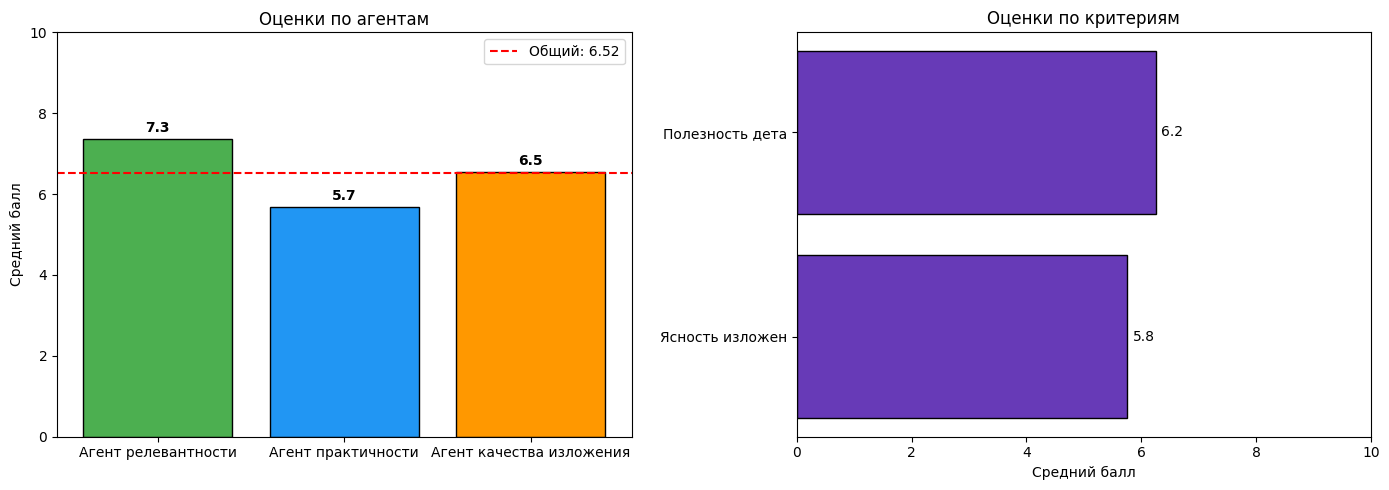


✓ График сохранён: /Users/andreisuhov/Desktop/llm/Journey_agent/data/testing_data/system_evaluation_chart.png


In [16]:
# Визуализация результатов
import matplotlib.pyplot as plt

# Оценки по агентам
agent_names = list(aggregated['per_agent'].keys())
agent_scores = [aggregated['per_agent'][name]['average'] for name in agent_names]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График 1: Средние оценки по агентам
colors = ['#4CAF50', '#2196F3', '#FF9800']
bars = axes[0].bar(agent_names, agent_scores, color=colors, edgecolor='black')
axes[0].set_ylim(0, 10)
axes[0].set_ylabel('Средний балл')
axes[0].set_title('Оценки по агентам')
axes[0].axhline(y=aggregated['overall']['average'], color='red', linestyle='--', label=f"Общий: {aggregated['overall']['average']}")
axes[0].legend()

# Добавляем значения на столбцы
for bar, score in zip(bars, agent_scores):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                 f'{score:.1f}', ha='center', va='bottom', fontweight='bold')

# График 2: Оценки по критериям
criteria_names = list(aggregated['per_criterion'].keys())
criteria_scores = [aggregated['per_criterion'][name]['average'] for name in criteria_names]

# Сокращаем названия критериев для читаемости
short_criteria = [name.split('_')[-1][:15] for name in criteria_names]

bars2 = axes[1].barh(short_criteria, criteria_scores, color='#673AB7', edgecolor='black')
axes[1].set_xlim(0, 10)
axes[1].set_xlabel('Средний балл')
axes[1].set_title('Оценки по критериям')

# Добавляем значения
for bar, score in zip(bars2, criteria_scores):
    axes[1].text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
                 f'{score:.1f}', va='center')

plt.tight_layout()
plt.savefig(testing_data_path / 'system_evaluation_chart.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ График сохранён: {testing_data_path / 'system_evaluation_chart.png'}")


In [17]:
# Показываем лучшие и худшие ответы
avg_cols = [f"{agent.name}_avg" for agent in agents]
evaluations_df['total_avg'] = evaluations_df[avg_cols].mean(axis=1)

print("\n🏆 ТОП-3 ЛУЧШИХ ОТВЕТА:")
print("-" * 60)
top3 = evaluations_df.nlargest(3, 'total_avg')
for _, row in top3.iterrows():
    print(f"\n  Запрос: {row['query'][:80]}...")
    print(f"  Общий балл: {row['total_avg']:.1f}/10")

print("\n\n⚠️ ТОП-3 ХУДШИХ ОТВЕТА (для улучшения):")
print("-" * 60)
bottom3 = evaluations_df.nsmallest(3, 'total_avg')
for _, row in bottom3.iterrows():
    print(f"\n  Запрос: {row['query'][:80]}...")
    print(f"  Общий балл: {row['total_avg']:.1f}/10")



🏆 ТОП-3 ЛУЧШИХ ОТВЕТА:
------------------------------------------------------------

  Запрос: В Питере хочу спланировать субботу: днём музей, вечером концерт чего-нибудь спок...
  Общий балл: 8.5/10

  Запрос: В Москве хочется культурный маршрут: выставка, потом театр в один вечер...
  Общий балл: 8.0/10

  Запрос: В Питере хочу что-нибудь необычное: может интерактивный музей и мастер-класс...
  Общий балл: 7.8/10


⚠️ ТОП-3 ХУДШИХ ОТВЕТА (для улучшения):
------------------------------------------------------------

  Запрос: Планирую субботу в Санкт-Петербурге: детское мероприятие, потом семейный рестора...
  Общий балл: 3.2/10

  Запрос: В Санкт-Петербурге хочется попробовать что-нибудь новое: мастер-класс или необыч...
  Общий балл: 4.8/10

  Запрос: Хочется сходить в Москве на кулинарный мастер-класс и потом поесть то, что приго...
  Общий балл: 5.2/10


In [18]:
# Финальный отчёт
print("\n" + "=" * 60)
print("📝 ИТОГОВЫЙ ОТЧЁТ")
print("=" * 60)

print(f"""
Дата оценки: {datetime.now().strftime('%Y-%m-%d %H:%M')}

Количество тестовых запросов: {len(test_queries)}
Успешно обработано: {len(responses_df[responses_df['status'] == 'success'])}
Ошибок: {len(responses_df[responses_df['status'] == 'error'])}

ОБЩИЙ БАЛЛ СИСТЕМЫ: {aggregated['overall']['average']}/10

Детализация по агентам:
""")

for agent_name, stats in aggregated['per_agent'].items():
    print(f"  • {agent_name}: {stats['average']}/10")

print(f"""
Сохранённые файлы:
  • Запросы: {queries_file}
  • Ответы: {responses_file}
  • Оценки: {evaluations_file}
  • График: {testing_data_path / 'system_evaluation_chart.png'}
""")



📝 ИТОГОВЫЙ ОТЧЁТ

Дата оценки: 2025-12-27 00:32

Количество тестовых запросов: 20
Успешно обработано: 20
Ошибок: 0

ОБЩИЙ БАЛЛ СИСТЕМЫ: 6.52/10

Детализация по агентам:

  • Агент релевантности: 7.35/10
  • Агент практичности: 5.68/10
  • Агент качества изложения: 6.55/10

Сохранённые файлы:
  • Запросы: /Users/andreisuhov/Desktop/llm/Journey_agent/data/testing_data/system_eval_queries.csv
  • Ответы: /Users/andreisuhov/Desktop/llm/Journey_agent/data/testing_data/system_eval_responses.csv
  • Оценки: /Users/andreisuhov/Desktop/llm/Journey_agent/data/testing_data/system_eval_scores.csv
  • График: /Users/andreisuhov/Desktop/llm/Journey_agent/data/testing_data/system_evaluation_chart.png

